In [1]:
import xarray as xr

file_path = 'M2T1NXFLX_5.12.4-20250612_044055/MERRA2_400.tavg1_2d_flx_Nx.20201010.nc4'
ds = xr.open_dataset(file_path)
print(list(ds.data_vars))


['BSTAR', 'CDH', 'CDM', 'CDQ', 'CN', 'DISPH', 'EFLUX', 'EVAP', 'FRCAN', 'FRCCN', 'FRCLS', 'FRSEAICE', 'GHTSKIN', 'HFLUX', 'HLML', 'NIRDF', 'NIRDR', 'PBLH', 'PGENTOT', 'PRECANV', 'PRECCON', 'PRECLSC', 'PRECSNO', 'PRECTOT', 'PRECTOTCORR', 'PREVTOT', 'QLML', 'QSH', 'QSTAR', 'RHOA', 'RISFC', 'SPEED', 'SPEEDMAX', 'TAUGWX', 'TAUGWY', 'TAUX', 'TAUY', 'TCZPBL', 'TLML', 'TSH', 'TSTAR', 'ULML', 'USTAR', 'VLML', 'Z0H', 'Z0M']


In [2]:
import xarray as xr
import numpy as np
import os

folder_path = 'M2T1NXFLX_5.12.4-20250612_044055'
dates = ["20201010", "20201011", "20201012", "20201013", "20201014", "20201015"]
file_paths = [os.path.join(folder_path, f'MERRA2_400.tavg1_2d_flx_Nx.{date}.nc4') for date in dates]

convective_accum = None
stratiform_accum = None
lat_ref = None
lon_ref = None

for fp in file_paths:
    try:
        ds = xr.open_dataset(fp)
        print(f"Processing {fp}")
        
        # Use correct variable names for MERRA-2 flux product
        preccon = ds['PRECCON']  # Convective precipitation rate (kg/m2/s)
        preclsc = ds['PRECLSC']  # Stratiform precipitation rate (kg/m2/s)
        
        # Convert from kg/m2/s to mm/day (1 kg/m2/s = 86400 mm/day)
        preccon_mmday = preccon * 86400
        preclsc_mmday = preclsc * 86400
        
        # Subset to Indian region (approximate lat/lon bounds)
        preccon_region = preccon_mmday.sel(lat=slice(5, 37), lon=slice(66, 98))
        preclsc_region = preclsc_mmday.sel(lat=slice(5, 37), lon=slice(66, 98))
        
        # Squeeze time dimension if present
        preccon_2d = preccon_region.squeeze()
        preclsc_2d = preclsc_region.squeeze()
        
        # Initialize accumulators
        if convective_accum is None:
            convective_accum = np.zeros_like(preccon_2d)
            stratiform_accum = np.zeros_like(preclsc_2d)
            lat_ref = preccon_2d['lat'].values
            lon_ref = preccon_2d['lon'].values
        
        convective_accum += preccon_2d.values
        stratiform_accum += preclsc_2d.values
        
    except FileNotFoundError:
        print(f"File not found: {fp}")
    except KeyError:
        print(f"Variable not found in {fp}. Check MERRA-2 documentation for correct variable names.")

# Save the accumulated data and lat/lon for plotting later
import pickle
with open('convective_accum.pkl', 'wb') as f:
    pickle.dump(convective_accum, f)
with open('stratiform_accum.pkl', 'wb') as f:
    pickle.dump(stratiform_accum, f)
with open('lat_ref.pkl', 'wb') as f:
    pickle.dump(lat_ref, f)
with open('lon_ref.pkl', 'wb') as f:
    pickle.dump(lon_ref, f)

print('Data processing complete. Accumulated convective and stratiform rainfall saved for plotting.')


Processing M2T1NXFLX_5.12.4-20250612_044055\MERRA2_400.tavg1_2d_flx_Nx.20201010.nc4
Processing M2T1NXFLX_5.12.4-20250612_044055\MERRA2_400.tavg1_2d_flx_Nx.20201011.nc4
Processing M2T1NXFLX_5.12.4-20250612_044055\MERRA2_400.tavg1_2d_flx_Nx.20201012.nc4
Processing M2T1NXFLX_5.12.4-20250612_044055\MERRA2_400.tavg1_2d_flx_Nx.20201013.nc4
Processing M2T1NXFLX_5.12.4-20250612_044055\MERRA2_400.tavg1_2d_flx_Nx.20201014.nc4
Processing M2T1NXFLX_5.12.4-20250612_044055\MERRA2_400.tavg1_2d_flx_Nx.20201015.nc4
Data processing complete. Accumulated convective and stratiform rainfall saved for plotting.


NameError: name 'lon2d' is not defined

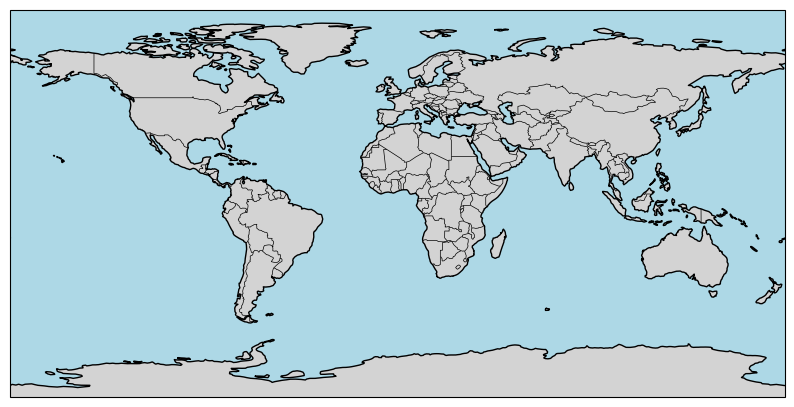

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Collapse 3D data (time, lat, lon) to 2D (lat, lon)
convective_2d = np.nansum(convective_accum, axis=0)
stratiform_2d = np.nansum(stratiform_accum, axis=0)

# Plotting function
def plot_precip(data, title, cmap='viridis', vmin=None, vmax=None):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Contour plot
    im = ax.contourf(lon2d, lat2d, data, levels=30, cmap=cmap,
                     vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    plt.title(title, fontsize=14)
    cb = plt.colorbar(im, orientation='vertical', pad=0.05, aspect=30,
                      label='Accumulated Rainfall (mm)')
    plt.tight_layout()
    plt.show()

# Plot both convective and stratiform rainfall
plot_precip(convective_2d, "Accumulated Convective Rainfall (mm)", cmap="YlOrRd", vmax=np.nanpercentile(convective_2d, 98))
plot_precip(stratiform_2d, "Accumulated Stratiform Rainfall (mm)", cmap="YlGnBu", vmax=np.nanpercentile(stratiform_2d, 98))


C:\Users\HONOR\AppData\Local\Temp\ipykernel_6488\4216368407.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbars on the right


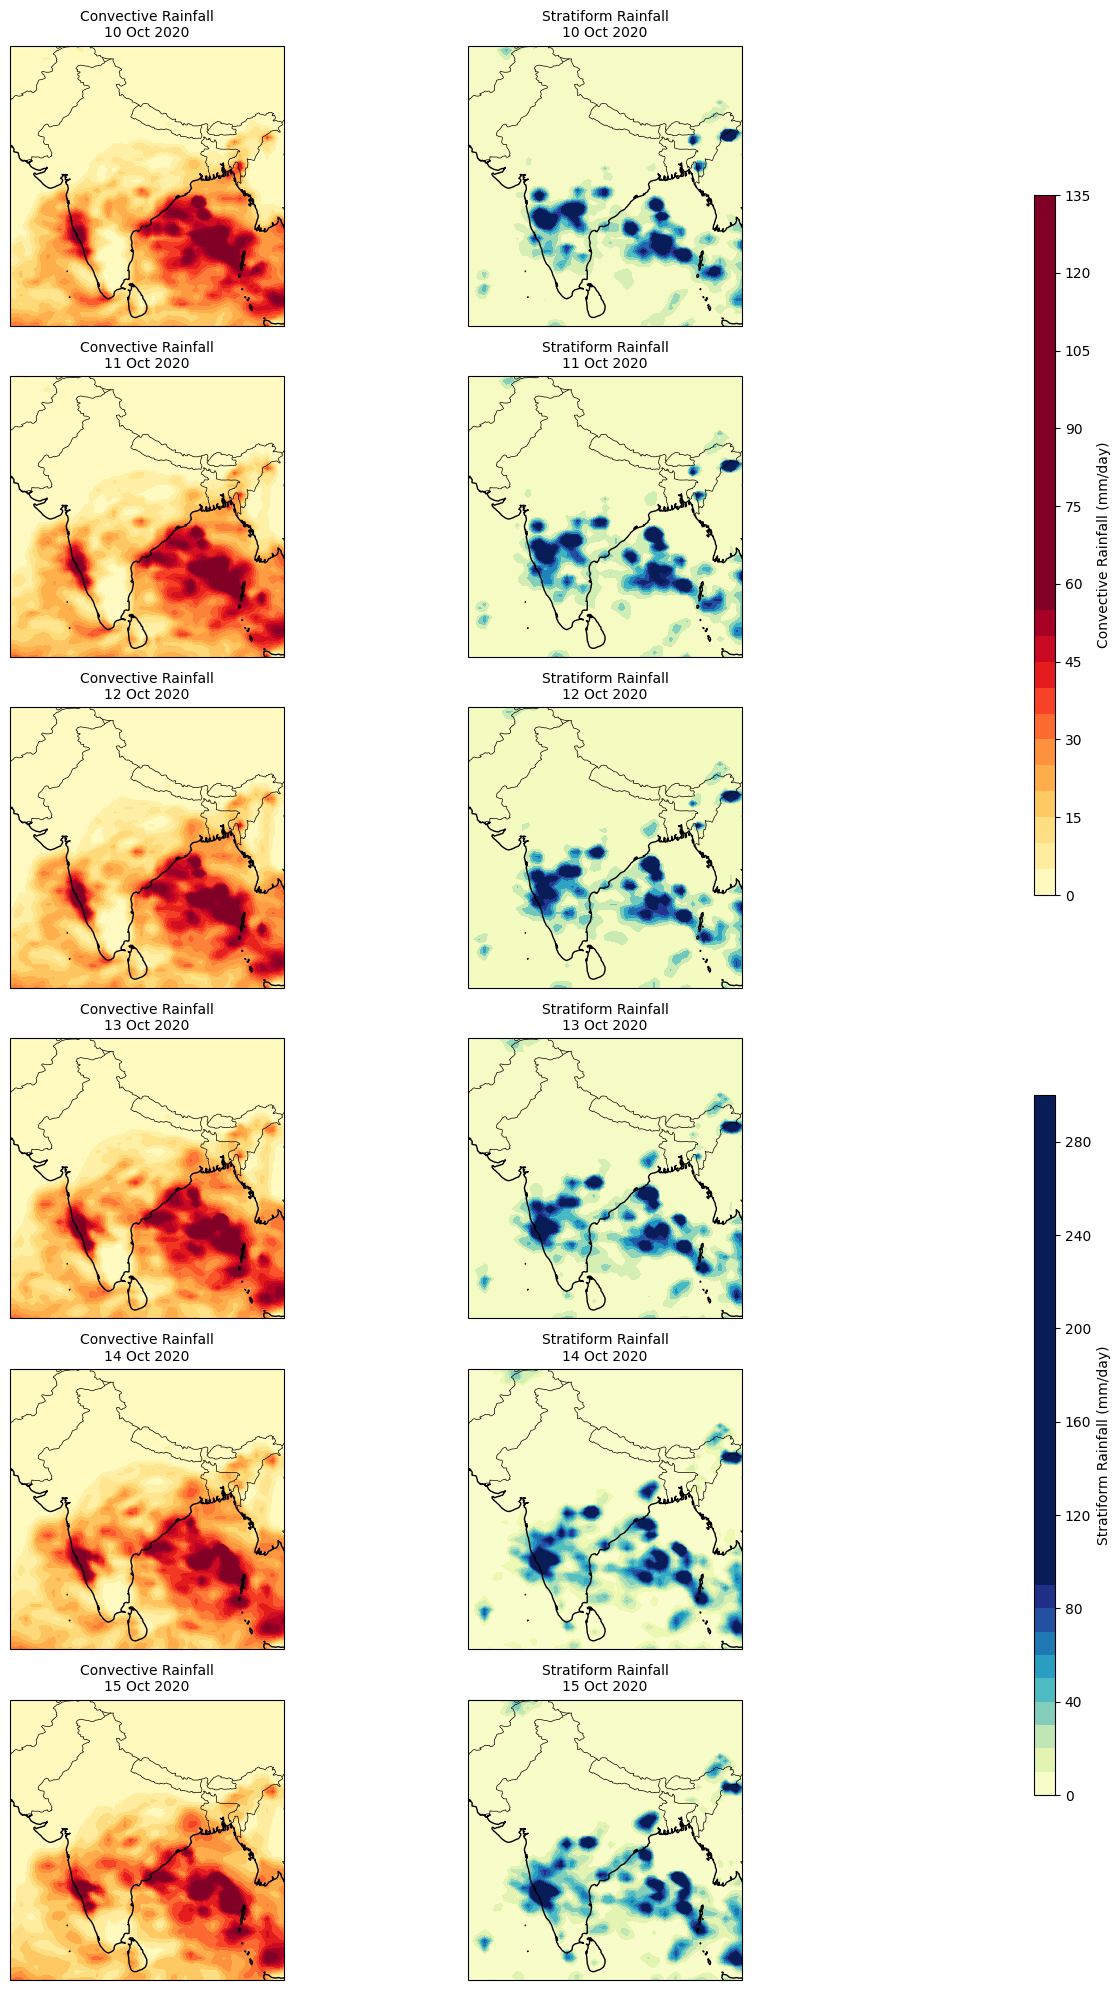

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Dummy data placeholders (replace with real arrays)
# lon2d, lat2d = np.meshgrid(longitude_array, latitude_array)
# convective_accum = np.random.rand(6, lat2d.shape[0], lon2d.shape[1]) * 100
# stratiform_accum = np.random.rand(6, lat2d.shape[0], lon2d.shape[1]) * 100

dates = ["10 Oct 2020", "11 Oct 2020", "12 Oct 2020",
         "13 Oct 2020", "14 Oct 2020", "15 Oct 2020"]

fig = plt.figure(figsize=(14, 20))  # Bigger figure

for t in range(6):
    # Convective subplot
    ax1 = fig.add_subplot(6, 2, 2*t + 1, projection=ccrs.PlateCarree())
    ax1.set_title(f"Convective Rainfall\n{dates[t]}", fontsize=10)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax1.add_feature(cfeature.LAND, facecolor='lightgray')
    ax1.add_feature(cfeature.OCEAN, facecolor='lightblue')
    im1 = ax1.contourf(
        lon2d, lat2d, convective_accum[t, :, :],
        levels=30, cmap="YlOrRd",
        vmax=np.nanpercentile(convective_accum[t], 98),
        transform=ccrs.PlateCarree()
    )

    # Stratiform subplot
    ax2 = fig.add_subplot(6, 2, 2*t + 2, projection=ccrs.PlateCarree())
    ax2.set_title(f"Stratiform Rainfall\n{dates[t]}", fontsize=10)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax2.add_feature(cfeature.LAND, facecolor='lightgray')
    ax2.add_feature(cfeature.OCEAN, facecolor='lightblue')
    im2 = ax2.contourf(
        lon2d, lat2d, stratiform_accum[t, :, :],
        levels=30, cmap="YlGnBu",
        vmax=np.nanpercentile(stratiform_accum[t], 98),
        transform=ccrs.PlateCarree()
    )

# Adjust layout
fig.subplots_adjust(hspace=0.4, wspace=0.1)

# Add vertical colorbars at the bottom
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.015, 0.35])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', label='Convective Rainfall (mm/day)')

cbar_ax2 = fig.add_axes([0.92, 0.1, 0.015, 0.35])
fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', label='Stratiform Rainfall (mm/day)')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbars on the right
plt.show()


In [ ]:
lon2d, lat2d = np.meshgrid(lon_ref, lat_ref)


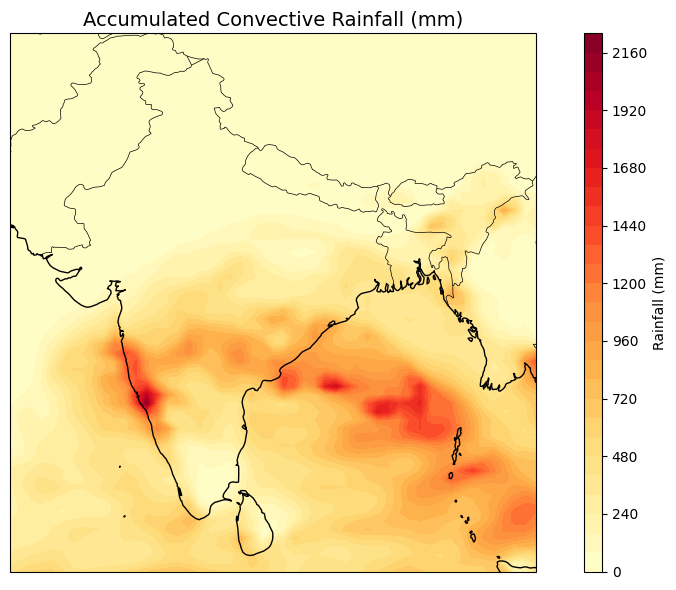

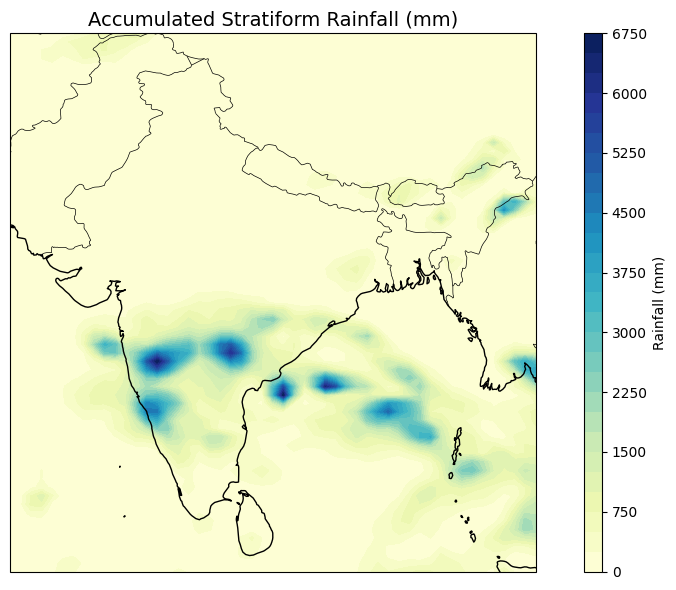

In [ ]:
plot_precip(convective_2d, "Accumulated Convective Rainfall (mm)", cmap="YlOrRd")
plot_precip(stratiform_2d, "Accumulated Stratiform Rainfall (mm)", cmap="YlGnBu")


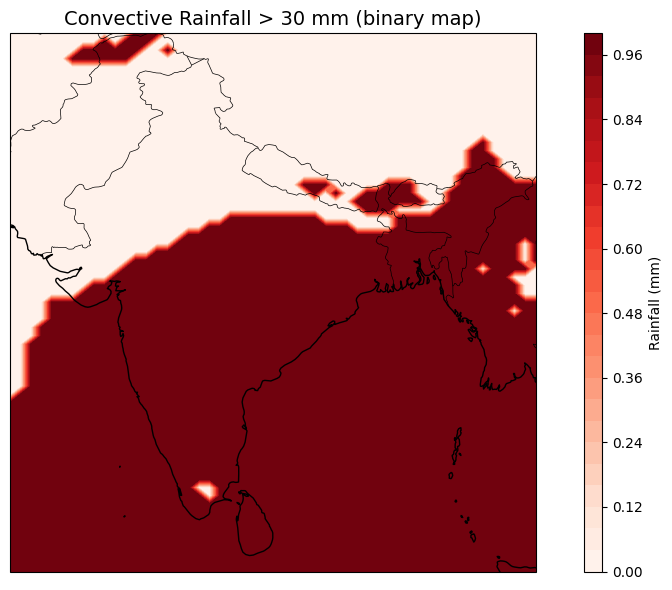

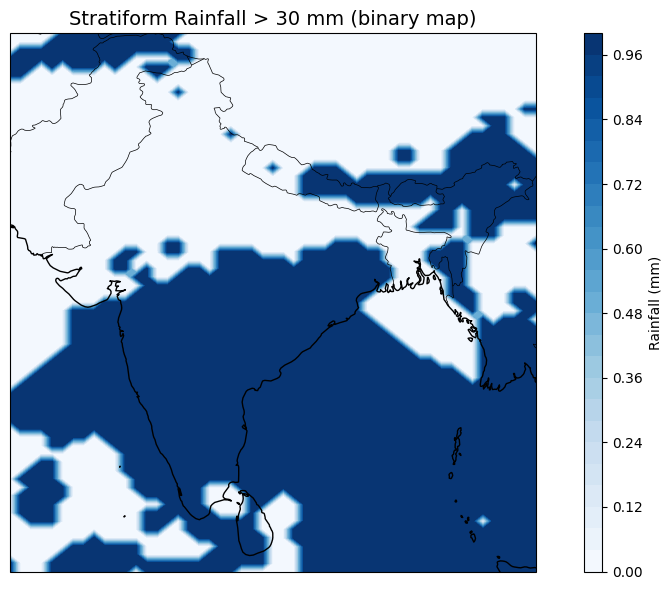

Convective Area (pixels): 2093
Stratiform Area (pixels): 1734


In [ ]:
threshold = 30  # mm

# Boolean mask where rainfall exceeds threshold
conv_mask = convective_2d > threshold
strat_mask = stratiform_2d > threshold

# Area in square degrees (approximate since we're not accounting for earth's curvature)
conv_area_deg2 = np.sum(conv_mask)
strat_area_deg2 = np.sum(strat_mask)

# Plot
plot_precip(conv_mask.astype(int), f"Convective Rainfall > {threshold} mm (binary map)", cmap="Reds")
plot_precip(strat_mask.astype(int), f"Stratiform Rainfall > {threshold} mm (binary map)", cmap="Blues")

print(f"Convective Area (pixels): {conv_area_deg2}")
print(f"Stratiform Area (pixels): {strat_area_deg2}")


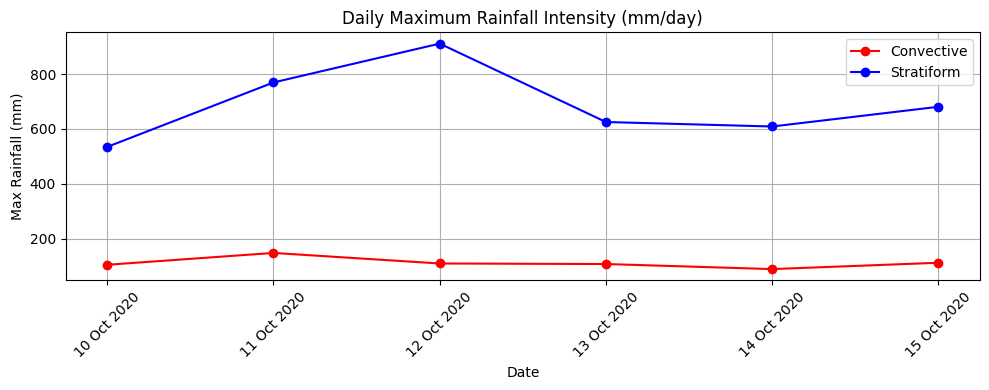

In [ ]:
daily_max_conv = []
daily_max_strat = []

for fp in file_paths:
    try:
        ds = xr.open_dataset(fp)
        preccon = ds['PRECCON'] * 86400
        preclsc = ds['PRECLSC'] * 86400
        preccon_region = preccon.sel(lat=slice(5, 37), lon=slice(66, 98)).squeeze()
        preclsc_region = preclsc.sel(lat=slice(5, 37), lon=slice(66, 98)).squeeze()
        
        daily_max_conv.append(np.nanmax(preccon_region.values))
        daily_max_strat.append(np.nanmax(preclsc_region.values))
    except:
        daily_max_conv.append(np.nan)
        daily_max_strat.append(np.nan)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dates, daily_max_conv, label="Convective", marker='o', color='red')
plt.plot(dates, daily_max_strat, label="Stratiform", marker='o', color='blue')
plt.title("Daily Maximum Rainfall Intensity (mm/day)")
plt.ylabel("Max Rainfall (mm)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
